In [2]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../..')

import Helpers
from Helpers.NeuralNetwork import NeuralNetwork

from Data import DatasetClasses

from Layers.FullyConnected import FullyConnected
from Layers.Activations import SoftMax
from Layers.Flatten import Flatten
from Layers.Initializers import He, Constant
from Layers.RBFKernel import RBFKernel

from Optimization.Optimizers import Sgd
from Optimization.Loss import CrossEntropyLoss
from Optimization.Constraints import L2_Regularizer

### Dataset


dataset Informations:
--------------------------------------------------
Training samples: 1168
Sample shape: (1, 8, 8)
Number of classes: 10
Test samples: 360
Dataset size in memory: 0.75 MB


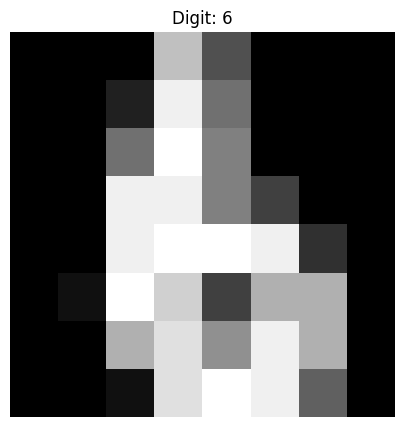

In [3]:
batch_size = 100 # Number of samples per batch (used for training)
digitdata = DatasetClasses.DigitData(batch_size)
digitdata.print_dataset_info()

### Architecture: Kernel-Based SVM Classifier

hyperparameters have to be choosen carefully to avoid having a bad accuracy at the end:
gamma is sensitive: too high or too low we get back to random predictions
number of features: too many features we get back to random predictions

In [4]:
def build_kernel_svm(input_dim, output_dim, prototypes_count=1000, data_layer=None, gamma=0.1):
    # Create optimizer with regularization for margin maximization (like SVM)
    learning_rate = 0.01
    optimizer = Sgd(learning_rate)
    regularizer = L2_Regularizer(alpha=0.01)  # Higher regularization for SVM-like behavior
    optimizer.add_regularizer(regularizer)
    
    # Initialize network
    weights_initializer = He()
    bias_initializer = Constant(0.0)  # Zero bias for SVM-like model
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Add layers
    net.append_layer(Flatten())  # Flatten input to vector
    
    # Add fixed kernel layer (non-trainable) with data layer for non-random supports
    # Using a higher gamma value for better class separation
    rbf_kernel = RBFKernel(input_dim=input_dim, prototype_count=prototypes_count, gamma=gamma, data_layer=data_layer)
    rbf_kernel.initialize(weights_initializer, bias_initializer)
    net.append_layer(rbf_kernel)
    
    # Add trainable layer for classification
    net.append_layer(FullyConnected(prototypes_count, output_dim))  # Map kernel features to classes
    
    # Add softmax for probabilities
    net.append_layer(SoftMax())
    
    # Set loss function
    net.loss_layer = CrossEntropyLoss()
    
    return net

### Train and Visualize Kernel SVM Model

Created new model


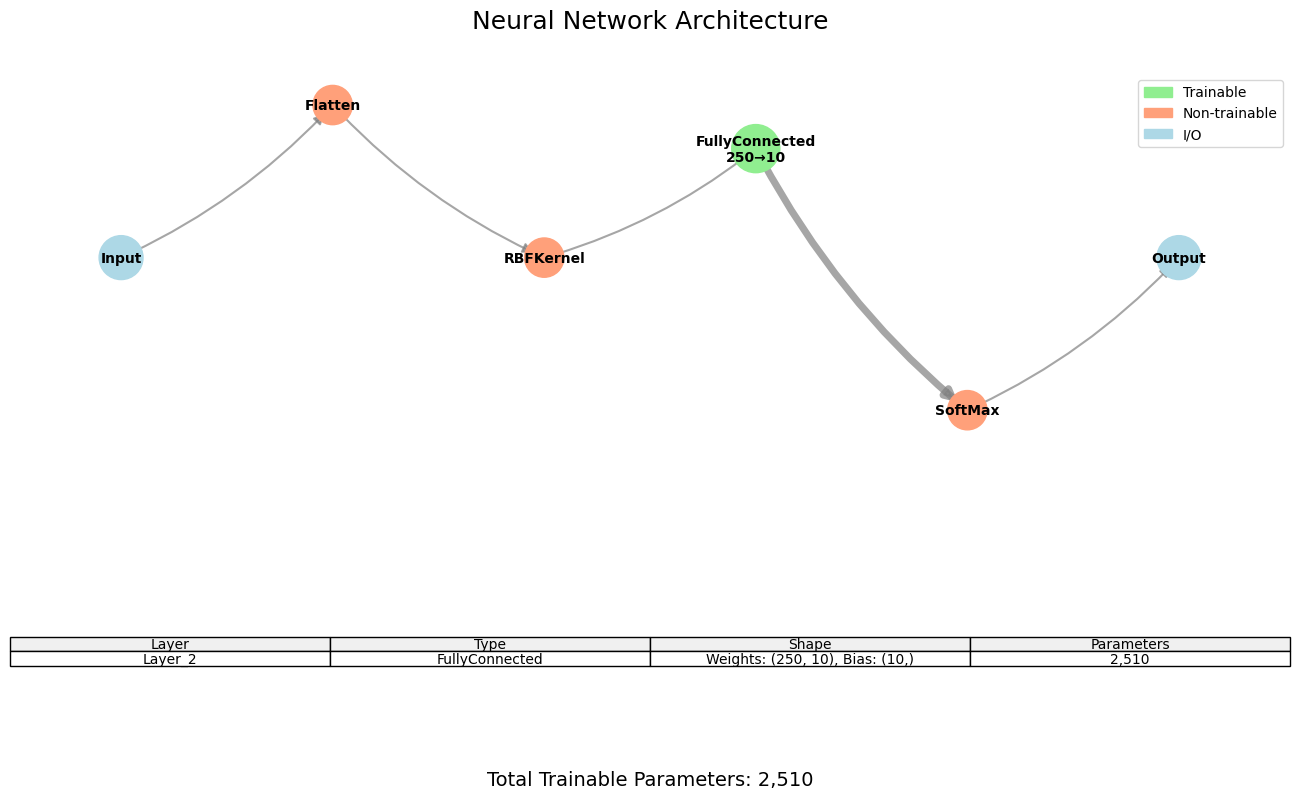

In [5]:
# classic parameters are 
# 10% as support vectors
# gamma = 1 / (n_features * X.var())
#putting random data_layer works also well but not as well as when using the data_layer
net = build_kernel_svm(input_dim=8*8, output_dim=10, prototypes_count=250, data_layer=digitdata, gamma=0.1)
net.data_layer = digitdata
print("Created new model")

# Visualize the initial network
fig = net.plot()

Détection automatique du type de problème: classification (basé sur CrossEntropyLoss)
Validation set detected and will be used for display.
 Iteration |         Loss |  Train Acc (%) |  Val Acc (%) | Elapsed Time
-----------------------------------------------------------------
         0 |   250.785396 |          10.20 |        12.64 | 0.04s
        10 |  1154.496286 |          29.20 |        30.48 | 0.40s
        20 |   419.169475 |          42.30 |        39.41 | 0.74s
        30 |   140.537840 |          61.30 |        57.62 | 1.07s
        40 |   183.613443 |          63.90 |        60.22 | 1.41s
        50 |   121.477758 |          72.70 |        72.86 | 1.74s
        60 |   110.899578 |          70.30 |        73.98 | 2.06s
        70 |   130.853597 |          76.80 |        75.09 | 2.37s
        80 |   111.095983 |          78.30 |        79.93 | 2.68s
        90 |    52.689917 |          82.80 |        87.36 | 3.00s
       100 |    46.909205 |          80.20 |        83.27 | 3

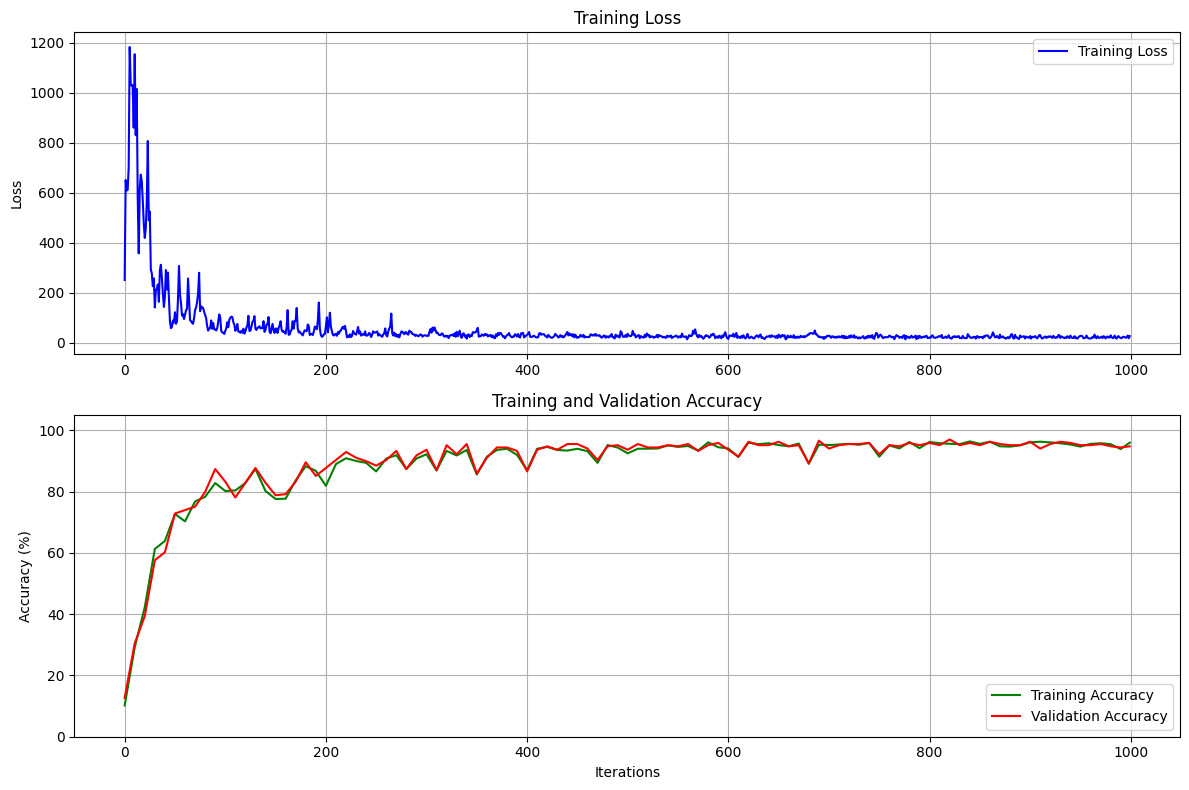

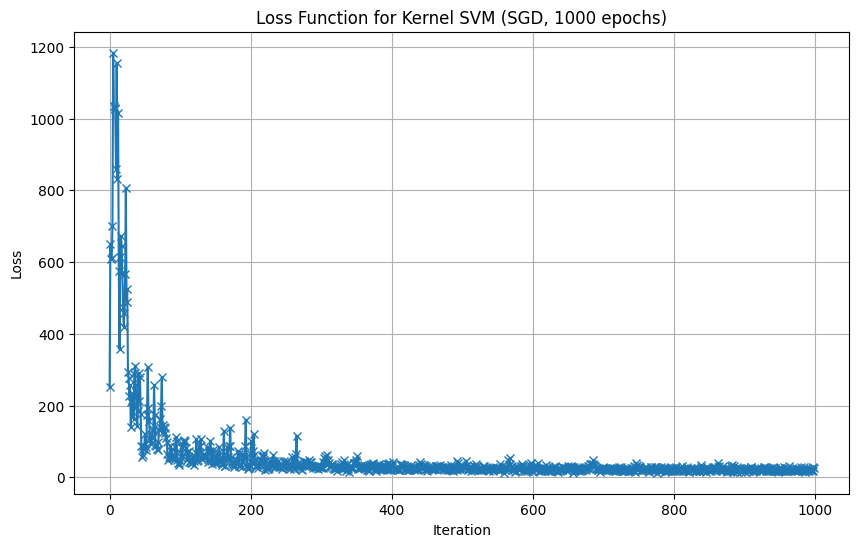

In [6]:
# Train the network
epochs = 1000
net.train(epochs)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(net.loss, '-x')
plt.title(f'Loss Function for Kernel SVM (SGD, {epochs} epochs)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Evaluate on Test Set

In [7]:
# Get the test set
data, labels = net.data_layer.get_test_set()

# Test the network on the test set
results = net.test(data)
accuracy = Helpers.Helpers.calculate_accuracy(results, labels)
print('\nOn the digits dataset, the kernel SVM achieves an accuracy of: ' + str(accuracy * 100) + '%')


On the digits dataset, the kernel SVM achieves an accuracy of: 96.66666666666667%


### Visualize Prototypes

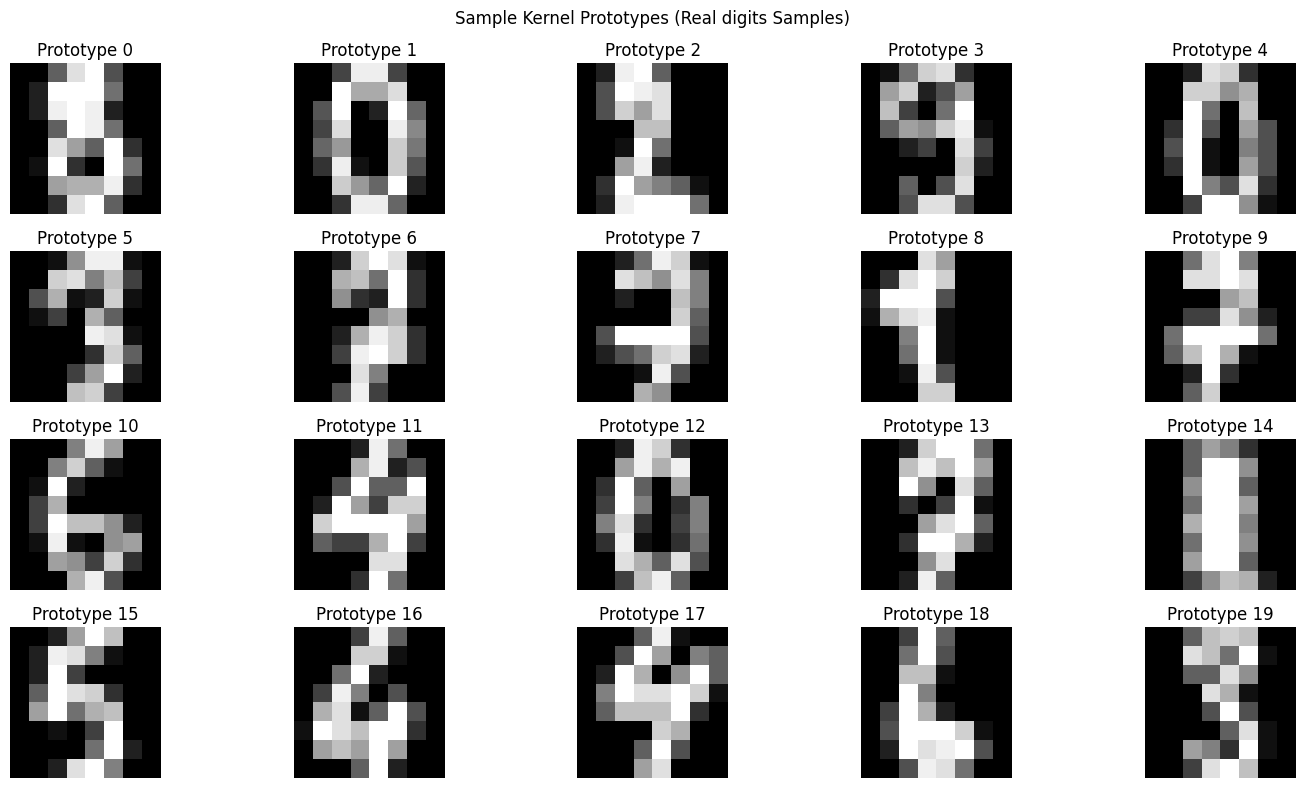

In [8]:
# Visualize prototypes from the kernel layer
kernel_layer = net.layers[1]  # RBF Kernel layer

# Check if the prototypes came from real data or were randomly initialized
using_real_data = hasattr(kernel_layer, 'using_real_data') and kernel_layer.using_real_data

plt.figure(figsize=(15, 8))
for i in range(min(20, kernel_layer.prototype_count)):
    plt.subplot(4, 5, i+1)
    # Reshape prototype to 28x28 image dimensions
    prototype_img = kernel_layer.prototypes[i].reshape(8, 8)
    plt.imshow(prototype_img, cmap='gray')
    plt.title(f'Prototype {i}')
    plt.axis('off')

if using_real_data:
    plt.suptitle('Sample Kernel Prototypes (Real digits Samples)')
else:
    plt.suptitle('Sample Kernel Prototypes (Random Initialization)')
    
plt.tight_layout()
plt.show()

In [9]:
# # Save the trained model
# os.makedirs('../trained', exist_ok = True)
# NeuralNetwork.save(os.path.join('../trained', 'SVM_itr'+str(iterations)), net)
# print("Model saved")

### Same with cifar


dataset Informations:
--------------------------------------------------
Training samples: 39000
Sample shape: (3, 32, 32)
Number of classes: 10
Test samples: 12000
Dataset size in memory: 597.66 MB


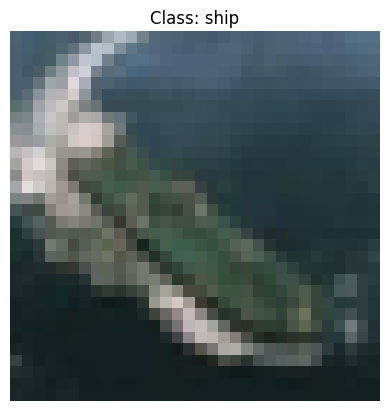

Created new model


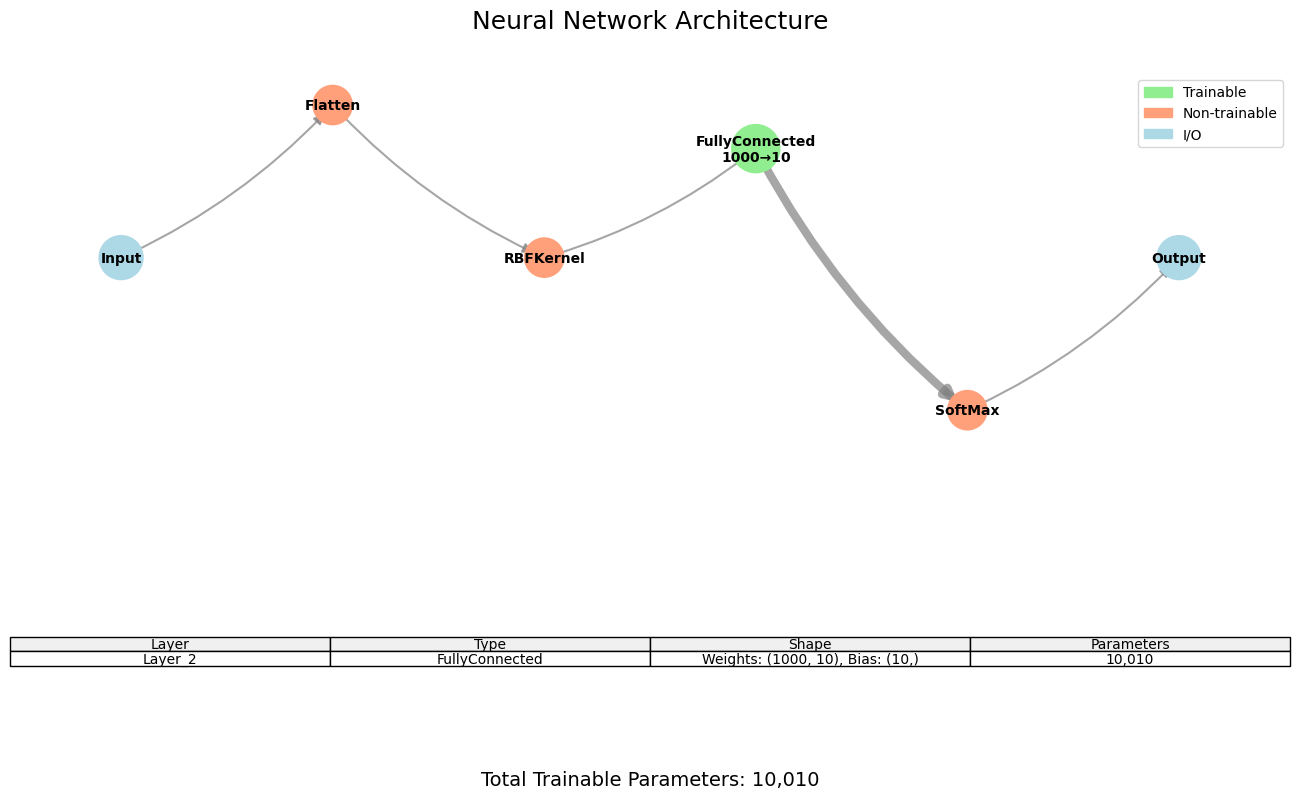

Détection automatique du type de problème: classification (basé sur CrossEntropyLoss)
Validation set detected and will be used for display.
 Iteration |         Loss |  Train Acc (%) |  Val Acc (%) | Elapsed Time
-----------------------------------------------------------------
         0 |   230.508839 |           8.60 |         6.20 | 16.02s
        10 |   231.585141 |           9.90 |        10.50 | 65.95s
        20 |   230.115062 |           8.40 |         9.30 | 111.49s
        29 |   230.930302 |          10.10 |         9.20 | 159.95s
-----------------------------------------------------------------
Training completed in 163.25s


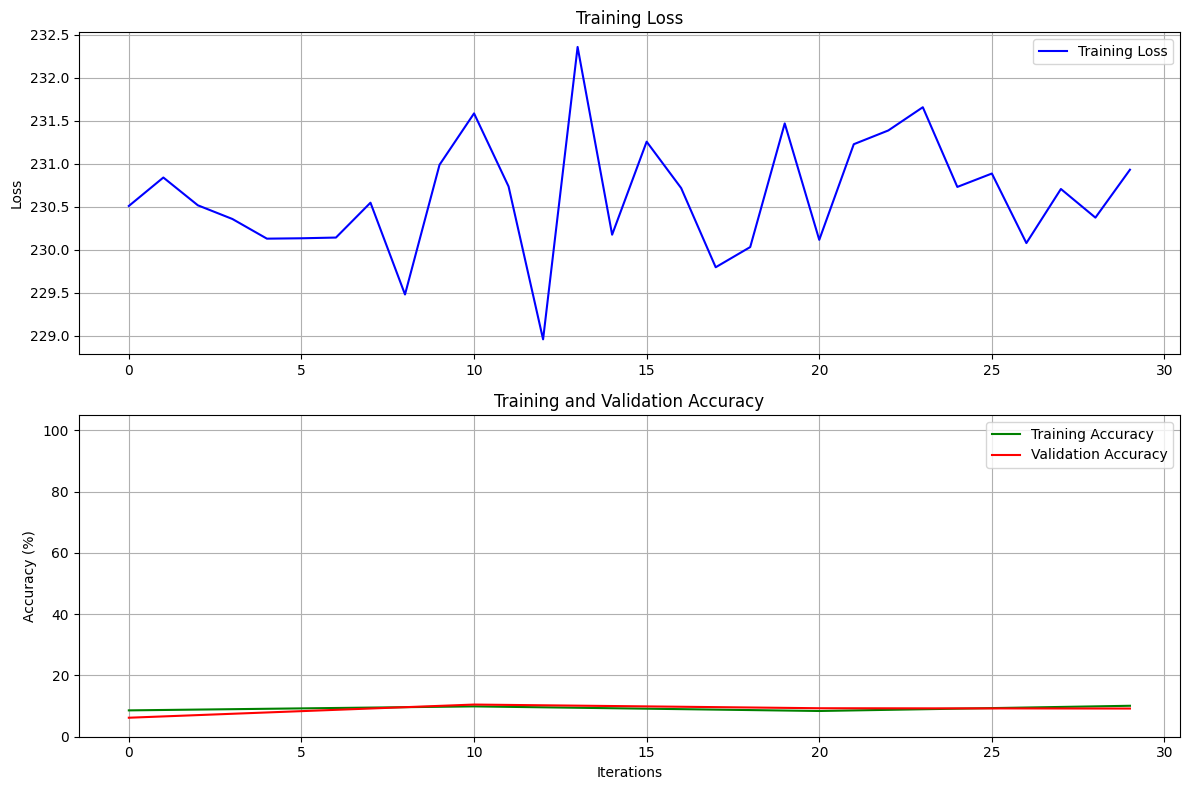

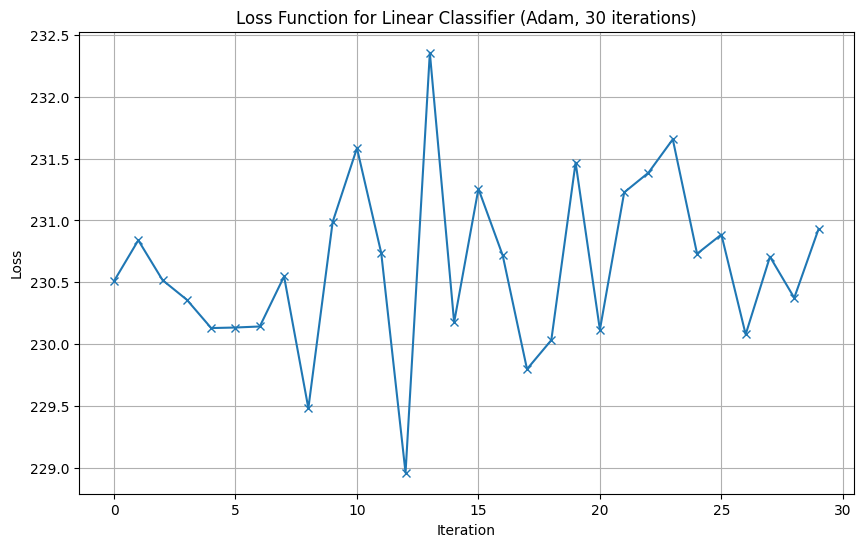


On the CIFAR dataset, the linear classifier achieves an accuracy of: 9.775%


In [ ]:
cifar = DatasetClasses.CifarData(100)
cifar.print_dataset_info()

iterations = 30

# Load or build the network
net = build_kernel_svm(input_dim=32*32*3, output_dim=10, prototypes_count=1000, data_layer=cifar, gamma=0.1)
net.data_layer = cifar
print("Created new model")

# Visualize the initial network
fig = net.plot()

# Train the network
net.train(iterations)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(net.loss, '-x')
plt.title(f'Loss Function for Linear Classifier (Adam, {iterations} iterations)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Get the test set
data, labels = net.data_layer.get_test_set()

# Test the network on the test set
results = net.test(data)
accuracy = Helpers.Helpers.calculate_accuracy(results, labels)
print('\nOn the CIFAR dataset, the linear classifier achieves an accuracy of: ' + str(accuracy * 100) + '%')